# Clasificador de Clientes de Empresa de Telecom
Conjunto de Datos de Kaggle [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) enfocado a programas de retención de clientes


## Lectura de datos

In [1]:
import numpy as np
import pandas as pd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Datos/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#Ver valores únicos de cada variable
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [5]:
#Eliminar IDs de los participantes
ID_costumer=df.customerID
df=df.drop('customerID', axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
#Convertimos TotalCharges a numérica.
#Revisar para que se utiliza errors='coerce'
df.TotalCharges =pd.to_numeric(df.TotalCharges, errors='coerce')

In [7]:
#¿cuántos valores nulos quedaron?

print(df.TotalCharges.isnull().sum())

df[df.TotalCharges.isnull()].head()

11


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No


In [8]:
#Remplazamos por 0 los valores nulos 
df = df.fillna(value=0)

In [9]:
#Revisamos las categorías y frecuencias de cada variable de tipo "objeto"

df_obj= df.select_dtypes("object",)  
for col in df_obj.columns:
    print(col)
    print (df[col].value_counts(),'\n')

gender
Male      3555
Female    3488
Name: gender, dtype: int64 

Partner
No     3641
Yes    3402
Name: Partner, dtype: int64 

Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64 

PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64 

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64 

TechSupport
No                     3473
Yes                    2044
No internet servi

In [10]:
yes_no_columns = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']

for i in yes_no_columns:
    df[i].replace(to_replace='Yes', value=1, inplace=True)
    df[i].replace(to_replace='No',  value=0, inplace=True)
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1


In [12]:
print(df.shape)
print(df.columns)

(7043, 20)
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [13]:
#Use one-hot encoding to convert categorical data to binary (0 or 1)
df = pd.get_dummies(df)
print(df.shape, '\n', df.columns)

(7043, 42) 
 Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer

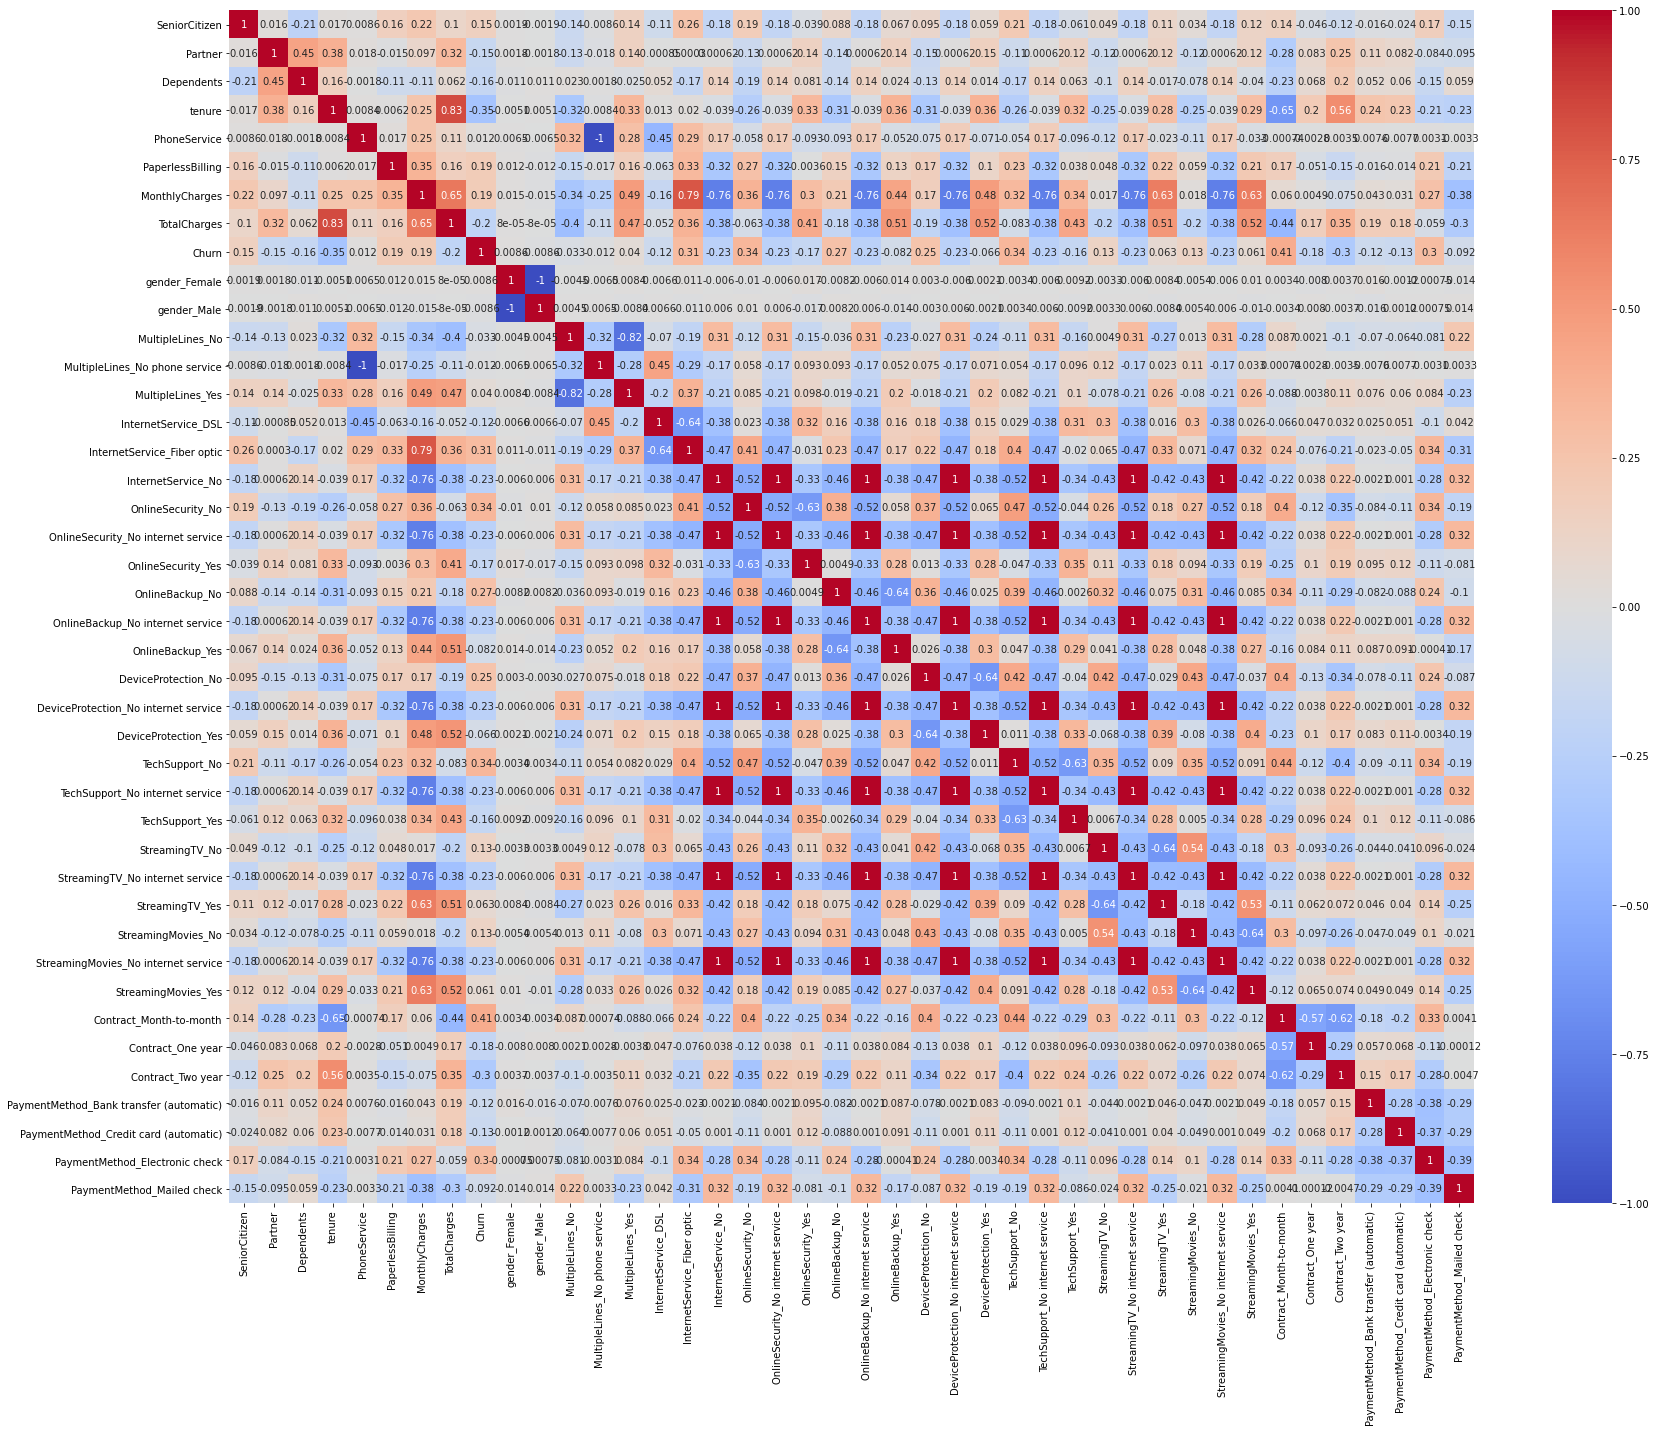

In [14]:
#Detectar variables redundantes 

def correlacion(dataframe, grafica = True):
    corr=dataframe.corr()                #creamos la matriz de correlación
    fig = plt.figure(figsize = (25,20))
    if grafica == True:
        sns.heatmap(corr, cmap="coolwarm", annot=True, square=False)
        fig.tight_layout()
    return corr

corr_matrix=correlacion(df, grafica=True)

In [15]:
#Borrar variables redundantes 

# Triangulo superior de la matriz de correlación en números absolutos
triangulo_sup = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), 1).astype(np.bool))

# Encontrar las columnas donde la correlación es 1
borrar = [column for column in triangulo_sup.columns if any(triangulo_s[column] == 1)]
borrar

['gender_Male',
 'MultipleLines_No phone service',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service']

In [16]:
df = df.drop(columns=borrar)   #eliminar columnas en la lista borrar

df = df.rename(columns={"gender_Female":"Gender"})   #renombrar columna (recordar que 0 sera Male y 1 Female)

print(df.shape[1], ' columnas: \n')
df.columns:


34  columnas: 

SeniorCitizen
Partner
Dependents
tenure
PhoneService
PaperlessBilling
MonthlyCharges
TotalCharges
Churn
Gender
MultipleLines_No
MultipleLines_Yes
InternetService_DSL
InternetService_Fiber optic
InternetService_No
OnlineSecurity_No
OnlineSecurity_Yes
OnlineBackup_No
OnlineBackup_Yes
DeviceProtection_No
DeviceProtection_Yes
TechSupport_No
TechSupport_Yes
StreamingTV_No
StreamingTV_Yes
StreamingMovies_No
StreamingMovies_Yes
Contract_Month-to-month
Contract_One year
Contract_Two year
PaymentMethod_Bank transfer (automatic)
PaymentMethod_Credit card (automatic)
PaymentMethod_Electronic check
PaymentMethod_Mailed check


## Balanceamos los casos

In [75]:
churners_number = len(df[df['Churn'] == 1])
print("Number of churners", churners_number)

churners = (df[df['Churn'] == 1])

non_churners = df[df['Churn'] == 0].sample(n=churners_number, random_state=6)
print("Number of non-churners", len(non_churners))
df_balanced = churners.append(non_churners)

Number of churners 1869
Number of non-churners 1869


## Separamos en conjunto de entrenamiento y prueba 

In [78]:
#Separar las etiquetas del conjunto de datos

Z =df_balanced.Churn
X= df_balanced.drop('Churn', axis=1)

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.3, shuffle=True, random_state=261)


In [80]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("TRAINING SET")
print("X: ", X_train.shape)
print("Z: ", Z_train.shape)
print('Clientes que cancelan:{:7.3f}%'.format(Z_train.mean()*100),'\n')

print("TEST SET")
print("X: ", X_test.shape)
print("Z: ", Z_test.shape)
print('Clientes que cancelan:{:7.3f}%'.format(Z_test.mean()*100))

TRAINING SET
X:  (2616, 33)
Z:  (2616,)
Clientes que cancelan: 49.541% 

TEST SET
X:  (1122, 33)
Z:  (1122,)
Clientes que cancelan: 51.070%


## Entrenamos y probamos el modelo

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
depth=3
criterio=["gini","entropy"]
clf=DecisionTreeClassifier(max_depth=depth,criterion=criterio[0],min_samples_split=5, random_state=0).fit(X_train,Z_train)
Z_pred = clf.predict(X_test)
print("Accuracy: {:4.2f}%".format(metrics.accuracy_score(Z_test, Z_pred)*100))

Accuracy: 76.29%


## Visualización del arbol de decisión

Wall time: 317 ms


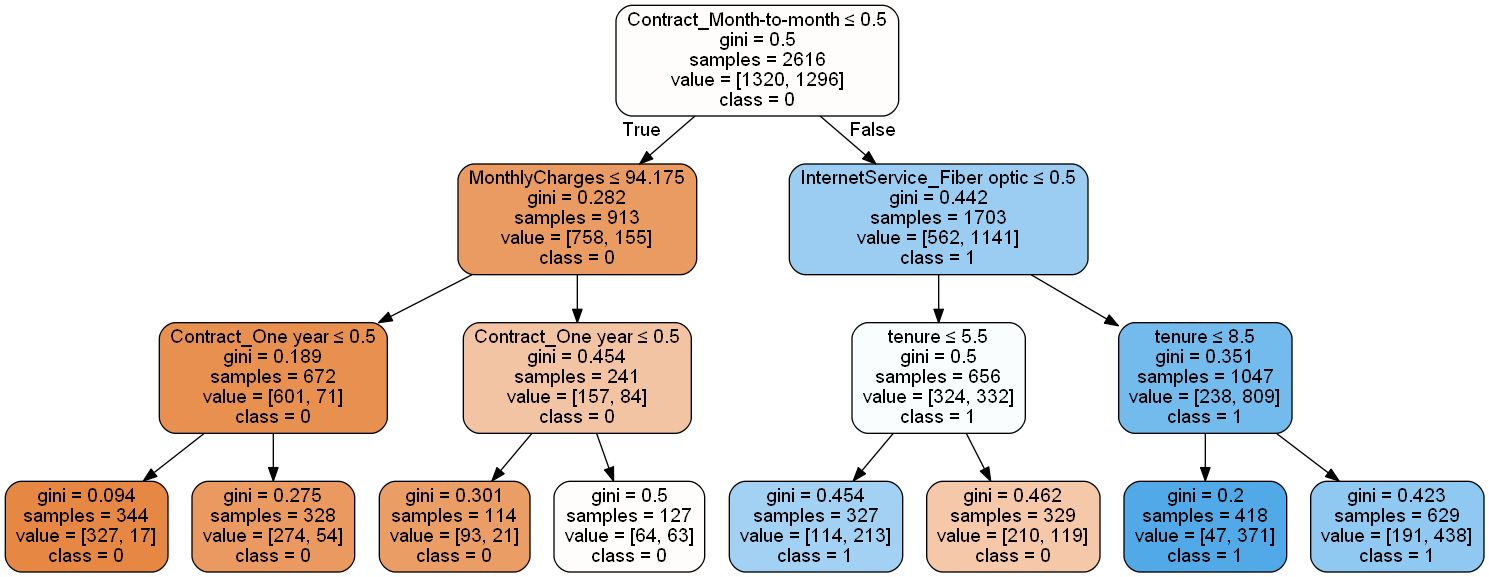

In [92]:
%%time
from sklearn.tree import export_graphviz  #exportar el arbol como un archivo .dot
from IPython.display import Image
from pydotplus import graph_from_dot_data

dot_data=export_graphviz(clf, rounded=True, filled=True, special_characters=True, 
                         feature_names = X.columns,max_depth=None,class_names=['0','1'])

graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

## Importancia de cada variable de acuerdo al modelo

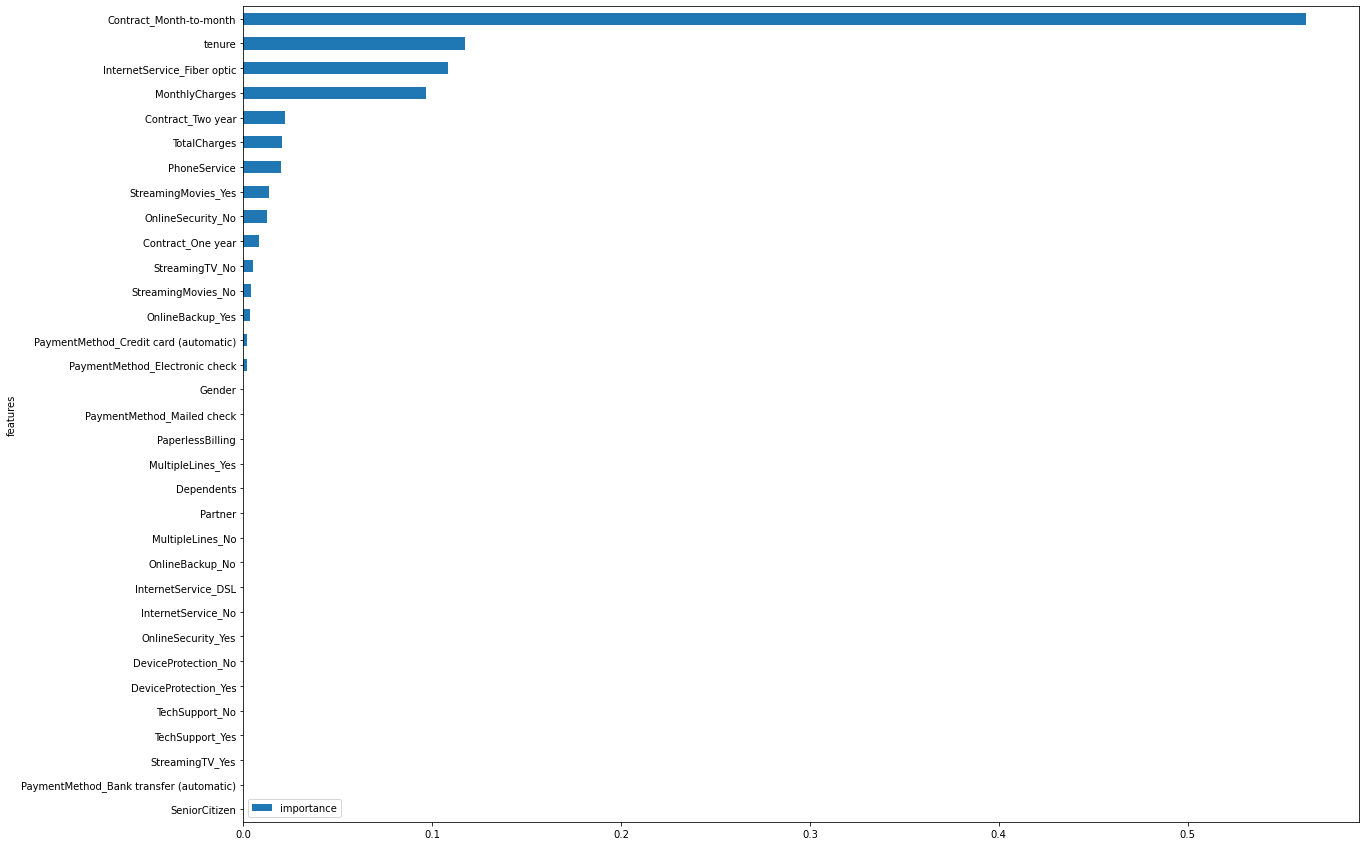

In [90]:
feature_df = pd.DataFrame()
feature_df['features'] = X.columns
feature_df['importance'] = clf.feature_importances_
feature_df.set_index(keys='features').sort_values(by='importance', ascending=True).plot(kind='barh', figsize=(20, 15))